# Transfer Learning Tutorial 
 
This tutorial demonstrates how to perform a simple transfer learning task with the data generated by Xiaogang.(https://ami2022group4.slack.com/archives/C03LKBAAJKW/p1656146461494769)
 
This tutorial is based on a tutorial on the TensorFlow page. You can therefore also use the following page as a reference. (https://www.tensorflow.org/tutorials/images/transfer_learning). The following tutorial is not about creating a perfect model, but only about showing how a transfer learning task could look like.
 #### [1. Imports](#title_1)
 #### [2. Setting up your directory ](#title_2)
 #### [3. Applying Transfer Learning ](#title_3)
 #### [4. Fine Tuning](#title_4)

##### Before you start the tutorial please download the above linked zip file from Xiaogang to your current path and unzip it.


<hr style="height:2px;border-width:0;color:black;background-color:black">

<a id="title_1"></a>
## 1. Imports
<br />

Required imports and loading image data.

In [16]:
import json
import os
from PIL import Image
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
# Defining FS dependencies
cropped_img_path = Path('resources', 'cropped_images_with_label')
cropped_img_path.is_dir()

True

In [25]:
# get current working directory

with Path(cropped_img_path, 'annotated_functional_test3_fixed_new.json').open() as f:
    data = json.load(f)


In [29]:
# get informations
categories = data['categories']
images = data['images']
annotations = data['annotations']

print(f"#categories: {len(categories)}")
print(f"#images: {len(images)}")
print(f"#annotations: {len(annotations)}")
print(f'Classes: {[x["name"] for x in categories]}')

#categories: 4
#images: 897
#annotations: 897
Classes: ['dent', 'other', 'rim', 'scratch']


<a id="title_2"></a>
## 2. Setting up your directory
<br />

The following block depends on your operating system.

In [31]:
Path("cropped_images_with_label/images/dent").mkdir(parents=True, exist_ok=True)
Path("cropped_images_with_label/images/other").mkdir(parents=True, exist_ok=True)
Path("cropped_images_with_label/images/rim").mkdir(parents=True, exist_ok=True)
Path("cropped_images_with_label/images/scratch").mkdir(parents=True, exist_ok=True)

#### 2.2 Move all files to the correct folder

If you have already moved the images you can skip this part.

In [39]:
# loop over all annotations
for annotation in annotations:

    # try:
    # get image informations
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    if not category_id:
        continue
    
    category_name = categories[int(category_id)]['name']

    # move file to correct directory
    current_image = Path(cropped_img_path, 'cropped_images', f'{image_id}.png')

    if not current_image.is_file():
        continue

    to_path = Path(cropped_img_path, 'images', category_name, f'{image_id}.png')
    to_path.parent.mkdir(parents=True, exist_ok=True)

    # move file
    os.replace(current_image, to_path)
    # except:
    # pass


<a id="title_3"></a>
## 3. Applying Transfer Learning
<br />

#### 3.1 Load data from disk

The data is then split into a training and validation set.

In [40]:
image_path = os.path.join(cropped_img_path, 'images')

train_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='training', seed=0, image_size=(224, 224))
val_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='validation', seed=0, image_size=(224, 224))

Found 731 files belonging to 4 classes.
Using 512 files for training.
Found 731 files belonging to 4 classes.
Using 219 files for validation.


2022-07-02 15:25:38.306714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-02 15:25:38.376996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-02 15:25:38.377014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-02 15:25:38.381802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

#### 3.2 Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### 3.3 Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. 

In [42]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

#### 3.4 Rescale pixel values
In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [43]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

#### 3.5 Create the base model from the pre-trained convnets
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

In [44]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


#### 3.6 Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [45]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### 3.7 Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#### 3.8 Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image

In [47]:
prediction_layer = tf.keras.layers.Dense(4)

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [48]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

#### 3.9 Compile the model
Compile the model before training it. 

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

#### 3.10 Check the initial performance

In [50]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

7/7 [==============================] - 4s 323ms/step - loss: 6.9281 - accuracy: 0.3607
initial loss: 6.93
initial accuracy: 0.36


#### 3.11 Train the model

In [51]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
16/16 [==============================] - 16s 833ms/step - loss: 6.9721 - accuracy: 0.3535 - val_loss: 5.5667 - val_accuracy: 0.4292
Epoch 2/10
 1/16 [>.............................] - ETA: 32s - loss: 3.0695 - accuracy: 0.4375

#### 3.12 Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

Text(0.5, 1.0, 'Training and Validation Accuracy')

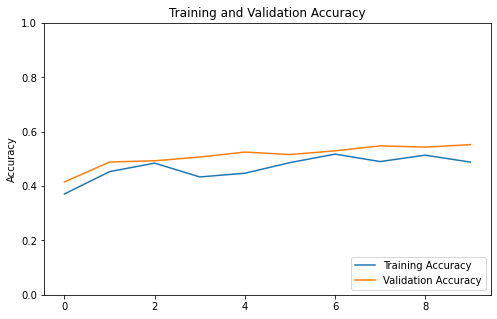

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')


<a id="title_4"></a>
## 4. Fine Tuning
<br />
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

#### 4.1 Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


#### 4.2 Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

#### 4.3 Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
16/16 [==============================] - 28s 2s/step - loss: 3.9778 - accuracy: 0.5703 - val_loss: 3.0664 - val_accuracy: 0.5936
Epoch 11/20
16/16 [==============================] - 23s 1s/step - loss: 3.3941 - accuracy: 0.6016 - val_loss: 2.9292 - val_accuracy: 0.6073
Epoch 12/20
16/16 [==============================] - 23s 1s/step - loss: 3.2680 - accuracy: 0.5977 - val_loss: 2.5669 - val_accuracy: 0.5890
Epoch 13/20
16/16 [==============================] - 24s 1s/step - loss: 3.1989 - accuracy: 0.6172 - val_loss: 2.4456 - val_accuracy: 0.6164
Epoch 14/20
16/16 [==============================] - 24s 1s/step - loss: 2.8382 - accuracy: 0.6250 - val_loss: 2.4065 - val_accuracy: 0.6438
Epoch 15/20
16/16 [==============================] - 26s 2s/step - loss: 2.4659 - accuracy: 0.6016 - val_loss: 2.2495 - val_accuracy: 0.6393
Epoch 16/20
16/16 [==============================] - 26s 2s/step - loss: 2.3909 - accuracy: 0.6582 - val_loss: 2.0386 - val_accuracy: 0.6484
Epoch 17/20
1

#### 4.4 Append performance to previous results

Text(0.5, 1.0, 'Training and Validation Accuracy')

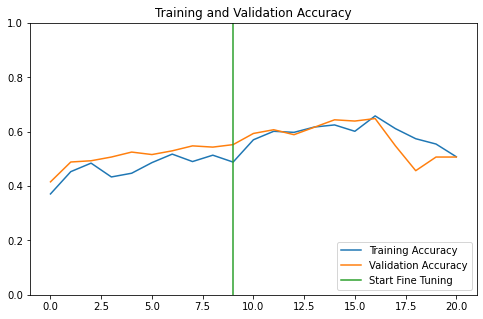

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')